# Linear regression models for predicting pollution

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, attribute_names = no2.get_data(target=no2.default_target_attribute, return_attribute_names=True);

## Quick visualization

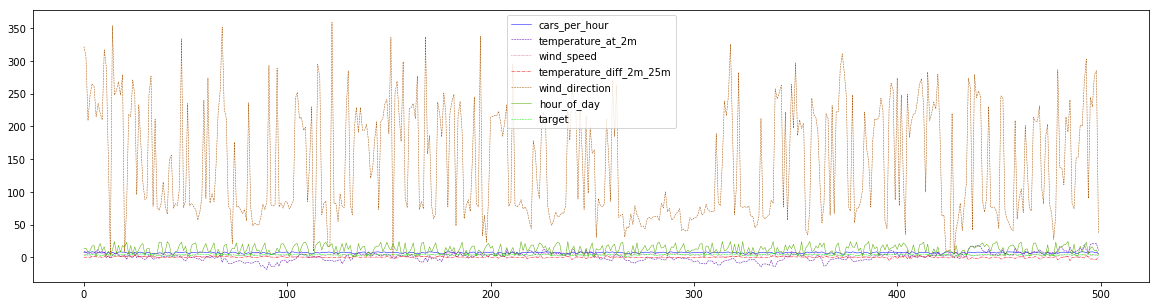

In [3]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(y,columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

If we plot the data, ordered by time of measurement, we can see that the wind direction (measured in angular degrees) is scaled very differently from the other features. Let's now zoom in to the other measures:

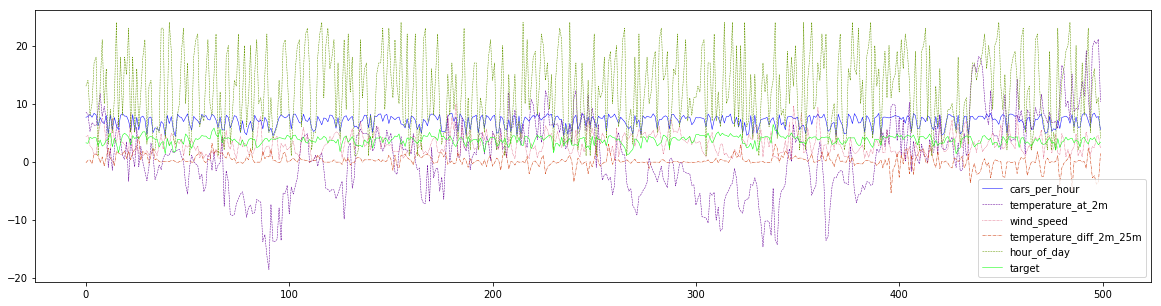

In [4]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

We can see that the target ($NO_2$ levels) seem to be correlated to the number of cars per hour, which makes sense because cars produce $NO_2$. Other influences (air temperature differences and wind) seem to have a more complex and subtle effect. Let's try to model these using linear regression models. We'll remove the 'day' feature to focus on the non-temporal aspects of this interaction (we are not aiming to predict future levels). There also doesn't seem to be a long term trend in the data, even though there are clear periodic trends in temperature.

In [5]:
# Remove the Days feature. We'll focus on the nonThis requires special treatment.
X = np.delete(X, 6, 1)
attribute_names = attribute_names[:-1]

## Feature distributions and dependencies
Next, we'll look at the distribution of each feature and its interaction with the target feature

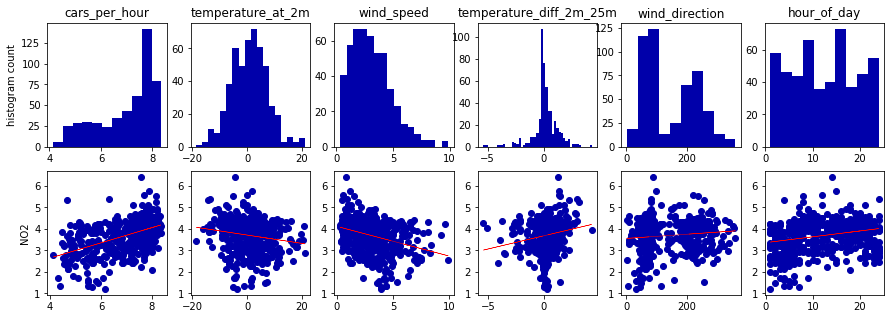

In [6]:
from numpy.polynomial.polynomial import polyfit

fig = plt.figure(figsize=(15,5))
for i, name in enumerate(attribute_names, start = 1):
    plt.subplot(2,len(attribute_names),i)
    plt.hist(X[:,i-1], bins="auto")
    plt.title(name)
    plt.subplot(2,len(attribute_names),i+len(attribute_names))
    plt.scatter(X[:,i-1], y)
    b, m = polyfit(X[:,i-1], y, 1)
    plt.plot(X[:,i-1], b + m * X[:,i-1], 'r-')
fig.get_axes()[0].set_ylabel("histogram count")
fig.get_axes()[1].set_ylabel("NO2");

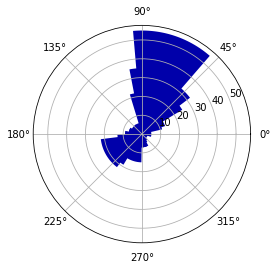

In [7]:
ax = plt.subplot(111, polar=True)
bars = ax.bar(np.arange(0.0, 2*np.pi, 2*np.pi/60), np.histogram(X[:,4], bins=60)[0])

## Model benchmark
It is clear that $NO2$ concentrations depend on a combination of these features, so we will now try to learn this complex relationship. We first evaluate a range of linear regression problems, i.e. Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN. Since we observed that somf features have very different scales, we'll also build pipelines of all these measures with an additional scaling step. For now, we'll stick to the default hyperparameter settings. 

In [8]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Evaluate with 3-fold cross-validation.
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor()]
models = np.array([[m, make_pipeline(StandardScaler(), m)] for m in models]).flatten()
xvals = [cross_validate(m, X, y, return_train_score= True, n_jobs=-1) for m in models]

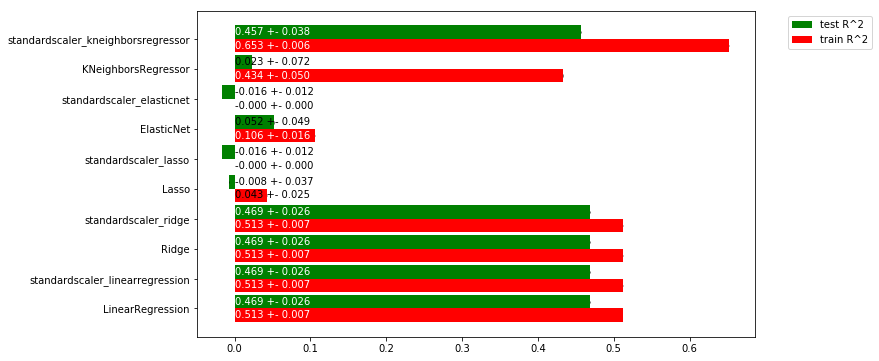

In [9]:
# Plotting
fig, ax = plt.subplots(figsize=(10,6))
width=0.45
test_scores = [x['test_score'] for x in xvals]
train_scores = [x['train_score'] for x in xvals]
ax.barh(np.arange(len(xvals)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')
ax.barh(np.arange(len(xvals))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')
for i, te, tr in zip(np.arange(len(xvals)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]
ax.set(yticks=np.arange(len(xvals))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

Linear regression and ridge regression don't surpass 0.5 $R^2$, yet don't seem to drastically overfit. Scaling doesn't seem to have any effect on them. Indeed, linear models can adjust their coefficients to be smaller on features with larger values, so often do not need scaling. This is very different for kNN, which performs poorly without scaling, but with scaling it is almost on par with linear regression and ridge regression. Lasso and ElasticNet are catastrophically bad in their default settings, and adding scaling actually seems to hurt performance.

## Regularization 
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. We run a grid search over these ranges, using 3-fold cross-valdation, and plot both the training and test error.

In [10]:
from sklearn.model_selection import GridSearchCV

param_a = {'alpha': np.logspace(-12, 12, num=22)}
param_elastic = {'l1_ratio': np.linspace(0, 1, num=11),
                 'alpha': np.logspace(-12, 12, num=25)}
param_k = {'kneighborsregressor__n_neighbors': np.geomspace(1, 60, num=12, dtype=int)[1:]}
models = [Ridge(), Lasso(), make_pipeline(StandardScaler(), KNeighborsRegressor()), ElasticNet()]
grids = [param_a,param_a,param_k,param_elastic]
grid_searches = [GridSearchCV(m,grid,n_jobs=-1).fit(X,y) for m,grid in zip(models,grids)]

In [11]:
# Generic plot for 1D grid search
def plot_tuning(grid_search, param_name, ax):
    """
    grid_search: the result of the GridSearchCV
    param_name: the name of the parameter that is being varied
    """
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend(loc='lower left')
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp,bs+0.01,"  best:{:.2E}, R2:{:.4f}".format(bp,bs))

# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

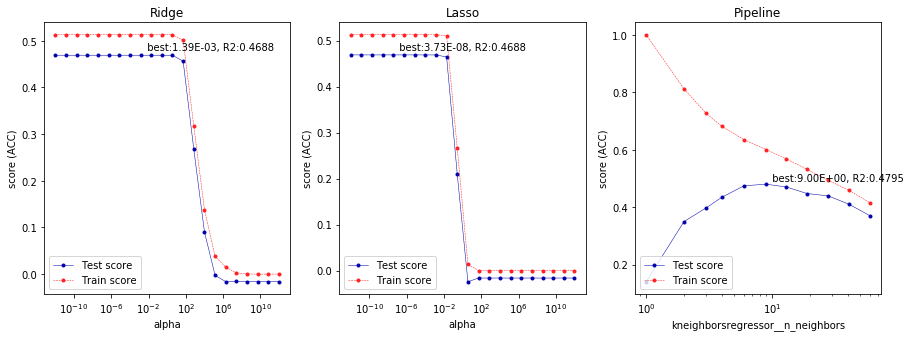

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for grid_search, param, ax in zip(grid_searches[0:3],['alpha','alpha','kneighborsregressor__n_neighbors'],axes):
    plot_tuning(grid_search, param, ax)

Ridge and Lasso behave very similarly, producing the same optimal result for small alpha's (small amounts of regularization), and then quickly dropping down to default performance (0 $R^2$) around alpha=0.1. Any more regularization makes the model completely underfit the data. The only difference is that Ridge has a slightly more gradual descent than Lasso. kNN yields a slightly better score (0.479 $R^2$) after scaling and tuning. It has a clear optimum around 9 nearest neighbors, after which it gradually starts overfitting.

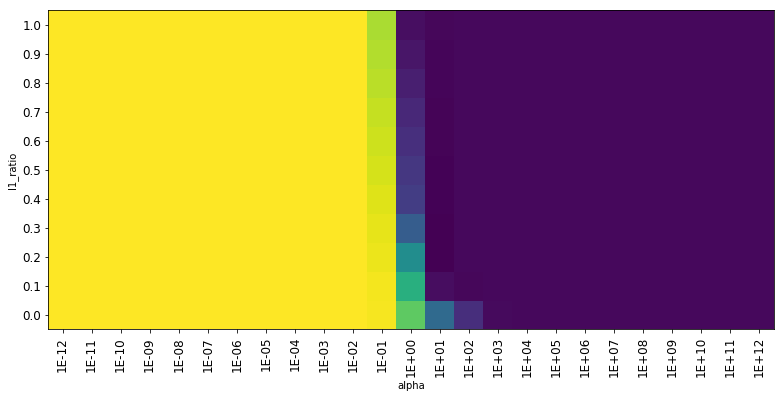

In [13]:
scores = np.array(pd.DataFrame(grid_searches[3].cv_results_).mean_test_score).reshape(25, 11).T
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 1, figsize=(13, 13))
heatmap(scores, xlabel='alpha', xticklabels=list(map(lambda n: "%.E" % n, param_elastic['alpha'])),
        ylabel='l1_ratio', yticklabels=np.around(param_elastic['l1_ratio'],4), cmap="viridis", fmt="%.2f", ax=axes);

For ElasticNet we see the same sudden drop in performance around alpha=0.1. For l1_ratio=0, it is identical to Ridge, showing a more gradual descent. For l1_ration=1, it is identical to Lasso, showing the same sharp performance drop.

Overall, it seems like we should be able to do better. Maybe we need a non-linear model for this dataset.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
scores = cross_val_score(RandomForestRegressor(n_estimators=500),X,y)
print("Random forest score (R2): {:.4f} +- {:.4f}".format(np.mean(scores),np.std(scores)))

Random forest score (R2): 0.5856 +- 0.0508


Another approach is to handle this problem as a time series prediction problem. Then we could leverage the values of the preceding points to make a prediction for the next points. We'll save that for another time.

## Visualizing coefficients
Finally, let's verify whether the different optimized linear models also find the same coefficients. We use alpha=0.001 since that appears to be (close to) optimal for all mdoels.

Indeed, they find almost _exactly_ the same coefficients (the markers overlap). cars_per_hour is the most influential, followed by temperature_diff_2m_25m and wind_speed. The others are nearly zero.

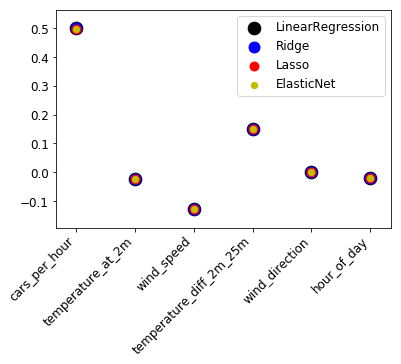

In [37]:
models = [LinearRegression(), Ridge(alpha=0.001), Lasso(alpha=0.001), ElasticNet(alpha=0.001)]
coeff = [m.fit(X,y).coef_ for m in models]

col = ['k','b','r','y']
plt.figure()
plt.xticks(rotation=45,ha="right")
for i in range(0,4):
    plt.scatter(attribute_names, coeff[i], s=(4-i)*40, c=col[i], label=models[i].__class__.__name__)
plt.legend();